https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import re
from collections import defaultdict

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    original_dir = "./signatures/"
    forged_dir = "./signatures/full_forg/"
    train_batch_size = 64
    train_number_epochs = 100

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        self.org = defaultdict(list)
        self.forg = defaultdict(list)
        for img_name, label in self.imageFolderDataset.imgs:
            _id, _ = self.format_image_name(img_name)
            self.org[int(_id)].append(img_name) if label is 1 else self.forg[int(_id)].append(img_name)
    
    def format_image_name(self, filename):
        ref = re.findall(r'\d+', filename)
        return ref[0], ref[1]
        
    def __getitem__(self,index):
        random_id = random.choice(list(self.org.keys()))
        img_0 = random.choice(self.org[random_id])
        
        is_label_same = random.choice([0, 1])
        if is_label_same is 0: 
            img_1 = random.choice(self.forg[random_id])
        else:
            img_1 = random.choice(self.org[random_id])
        
        img_0 = Image.open(img_0)
        img_1 = Image.open(img_1)
        img_0 = img_0.convert("L")
        img_1 = img_1.convert("L")
        
#         if self.should_invert:
#             img_org = PIL.ImageOps.invert(img_org)
#             img_forg = PIL.ImageOps.invert(img_forg)

        if self.transform is not None:
            img_0 = self.transform(img_0)
            img_1 = self.transform(img_1)
        
        return img_0, img_1 , torch.from_numpy(np.array([is_label_same],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
folder_dataset = dset.ImageFolder(root=Config.original_dir)

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]),
                                        should_invert=False)


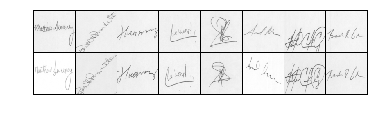

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [8]:
random.choice(['./signatures/full_org/original_1_1.png', './signatures/full_org/original_1_10.png', './signatures/full_org/original_1_11.png', './signatures/full_org/original_1_12.png', './signatures/full_org/original_1_13.png', './signatures/full_org/original_1_14.png', './signatures/full_org/original_1_15.png', './signatures/full_org/original_1_16.png', './signatures/full_org/original_1_17.png', './signatures/full_org/original_1_18.png', './signatures/full_org/original_1_19.png', './signatures/full_org/original_1_2.png', './signatures/full_org/original_1_20.png', './signatures/full_org/original_1_21.png', './signatures/full_org/original_1_22.png', './signatures/full_org/original_1_23.png', './signatures/full_org/original_1_24.png', './signatures/full_org/original_1_3.png', './signatures/full_org/original_1_4.png', './signatures/full_org/original_1_5.png', './signatures/full_org/original_1_6.png', './signatures/full_org/original_1_7.png', './signatures/full_org/original_1_8.png', './signatures/full_org/original_1_9.png'])

'./signatures/full_org/original_1_15.png'

In [10]:


# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
#         self.cnn1 = nn.Sequential(
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(1, 4, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(4),
            
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(4, 8, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(8),


#             nn.ReflectionPad2d(1),
#             nn.Conv2d(8, 8, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(8),
#         )

#         self.fc1 = nn.Sequential(
#             nn.Linear(8*100*100, 500),
#             nn.ReLU(inplace=True),

#             nn.Linear(500, 500),
#             nn.ReLU(inplace=True),

#             nn.Linear(500, 5))

#     def forward_once(self, x):
#         output = self.cnn1(x)
#         output = output.view(output.size()[0], -1)
#         output = self.fc1(output)
#         return output

#     def forward(self, input1, input2):
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)
#         return output1, output2

import torch
from torch import nn
import torch.nn.functional as F

from collections import OrderedDict
from typing import Dict
from torch.nn.init import xavier_uniform_

class SigNetModel(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self, normalize):
        super(SigNetModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=1)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.dense1 = nn.linear(256*3*3, 1024)
        self.dense2 = nn.linear(1024, 128)
        
        self.lrn = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.maxpool2d = nn.MaxPool2d(kernel_size=3, stride=2)
        self.relu = nn.ReLU(inplace=True)

    def forward_once(self, x):
        x = self.relu(self.conv1(x))
        x = self.lrn(x)
        x = self.maxpool2d(x)
        x = self.relu(self.conv2(x))
        x = self.lrn(x)
        x = self.maxpool2d(x)
        x = nn.Dropout2d(p=0.3)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.maxpool2d(x)
        x = nn.Dropout2d(p=0.3)
        
        x = x.view(x.shape[0], 256 * 3 * 3)
        x = self.relu(self.dense1(x))
        x = nn.Dropout(p=0.5)
        x = self.relu(self.dense2(x))
        return x
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive



In [12]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)


In [15]:
net = SigNetModel(normalize=True)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

ValueError: optimizer got an empty parameter list

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
#         img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)